In [1]:
from TradingView import Datafeed
import pandas as pd

Data = Datafeed()
prices_df = pd.DataFrame()

crypto_list = [('BTCUSD', 'COINBASE'),
               ('ETHUSD', 'COINBASE'),
               ('BNBUSD', 'BINANCE'),
               ('ADAUSD', 'BINANCE'),
               ('LUNAUSD', 'BINANCE'),
               ('XRPUSD', 'BINANCE'),
               ('LINKUSD', 'BINANCE'),
               ('CROUSD', 'BITTREX'),
               ('MANAUSD', 'BINANCE'),
               ('FTTUSD', 'FTX')]

for crypto in crypto_list:
    prices_df[crypto[0]] = Data.daily_close(symbol=crypto[0], exchange=crypto[1], 
                                            date_start_str='2020/01/01', date_end_str='2022/01/01')

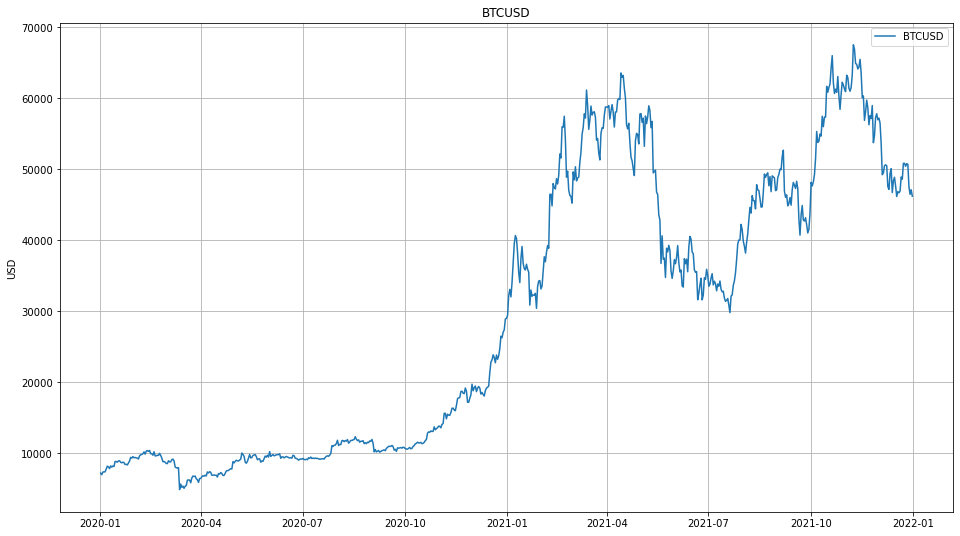

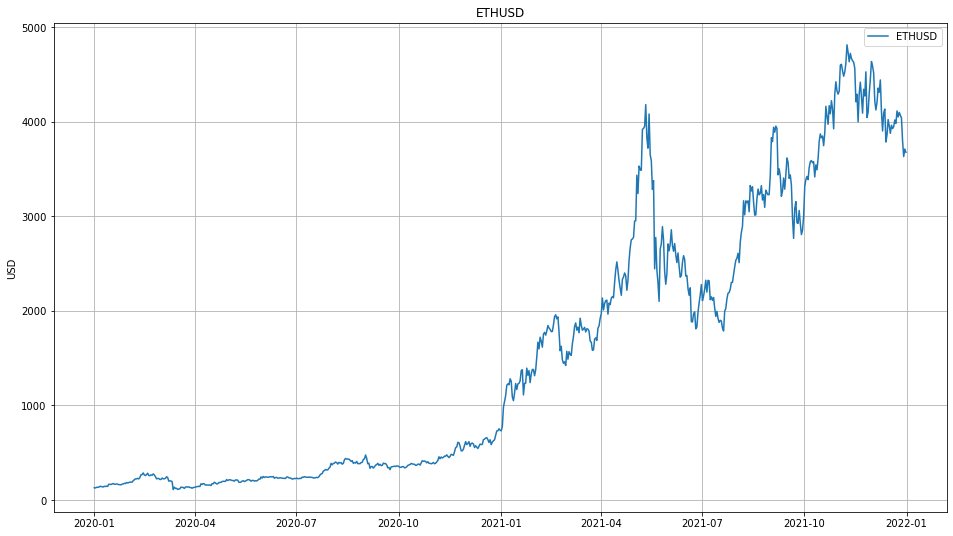

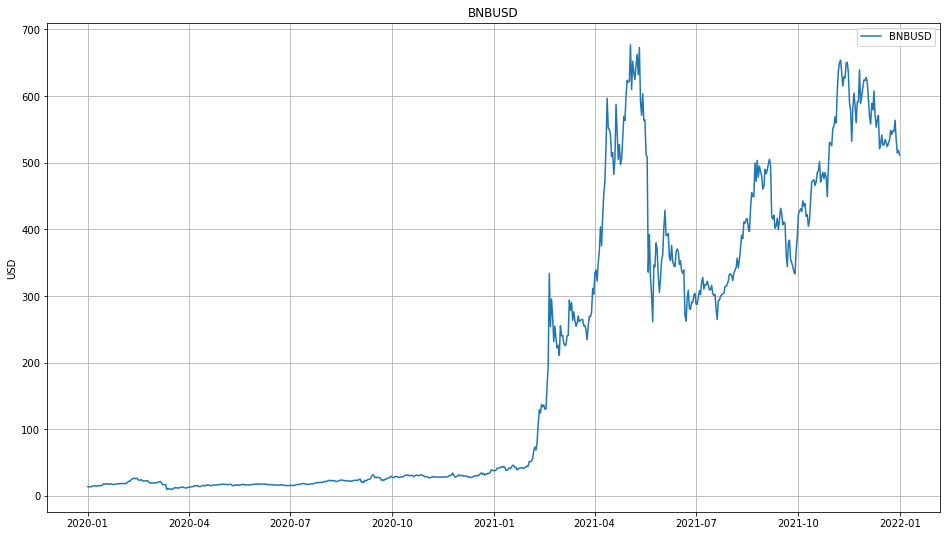

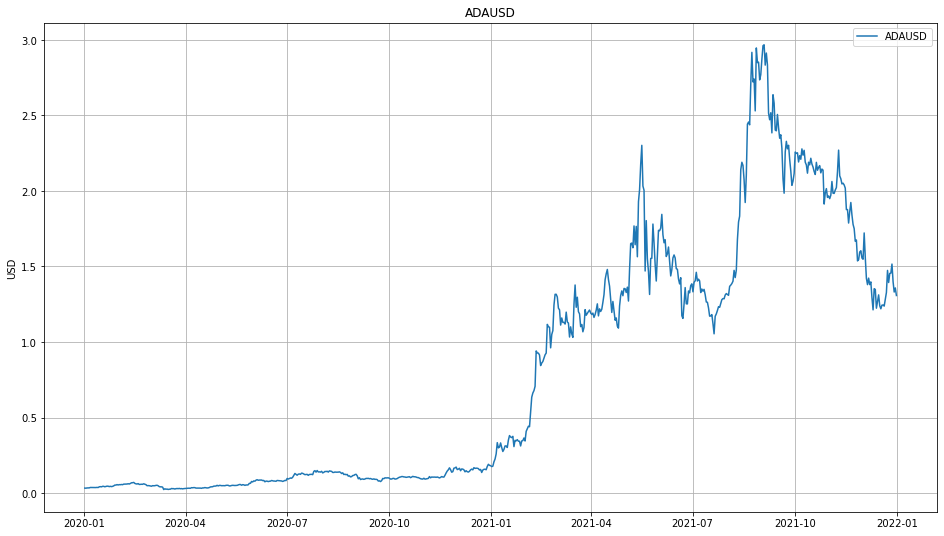

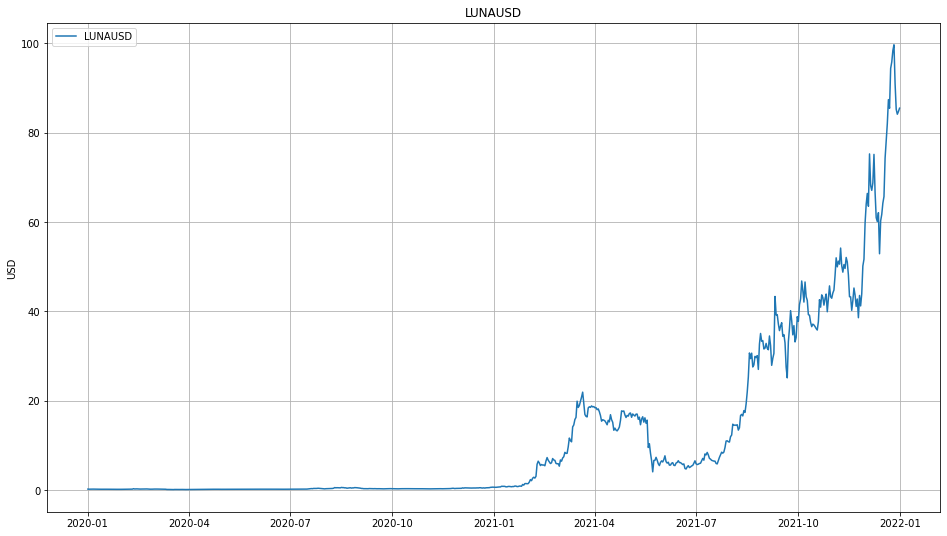

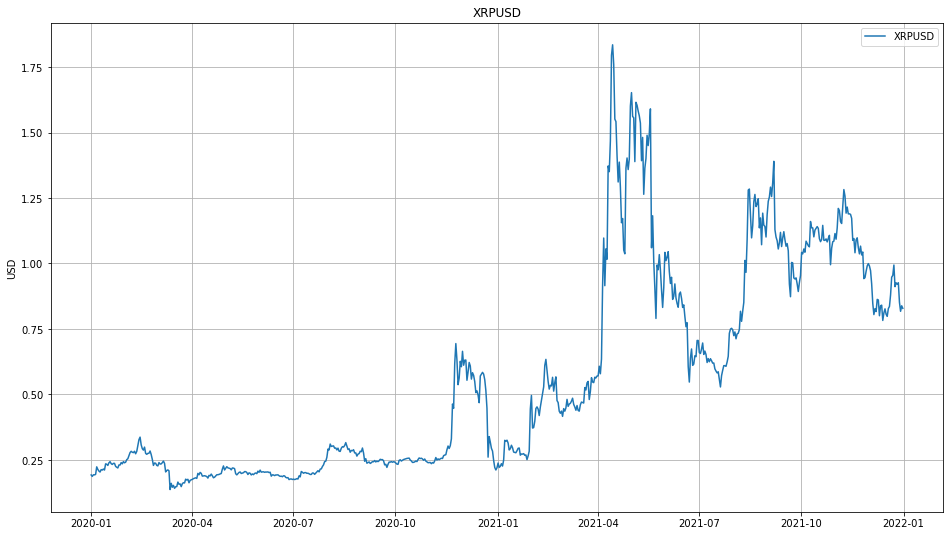

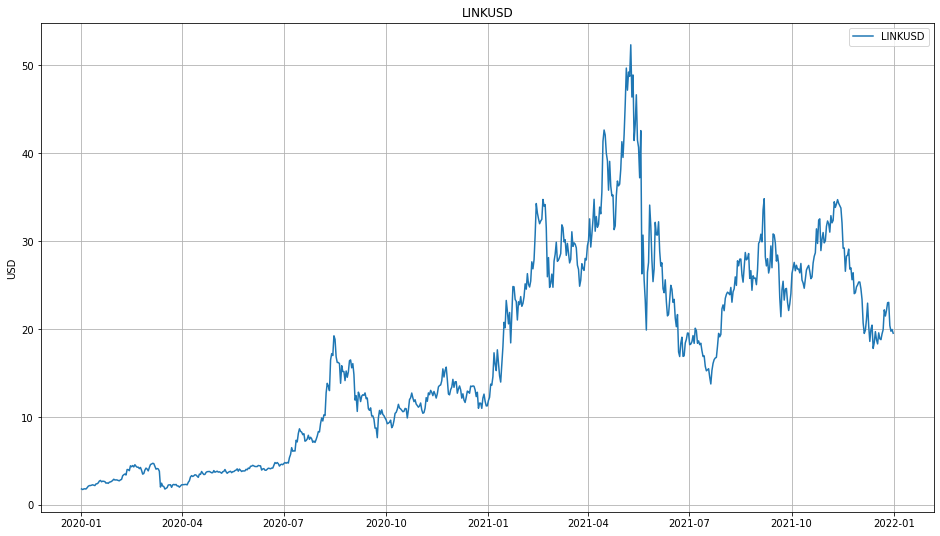

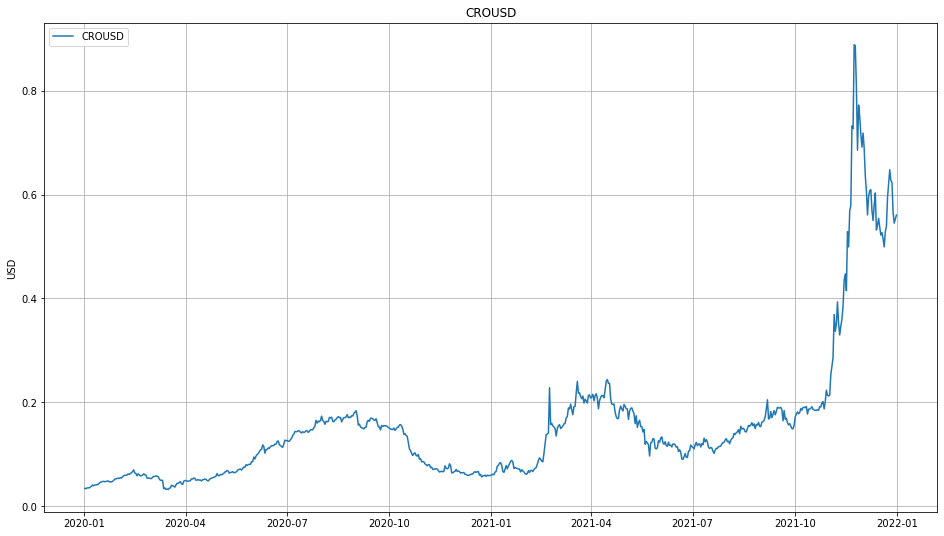

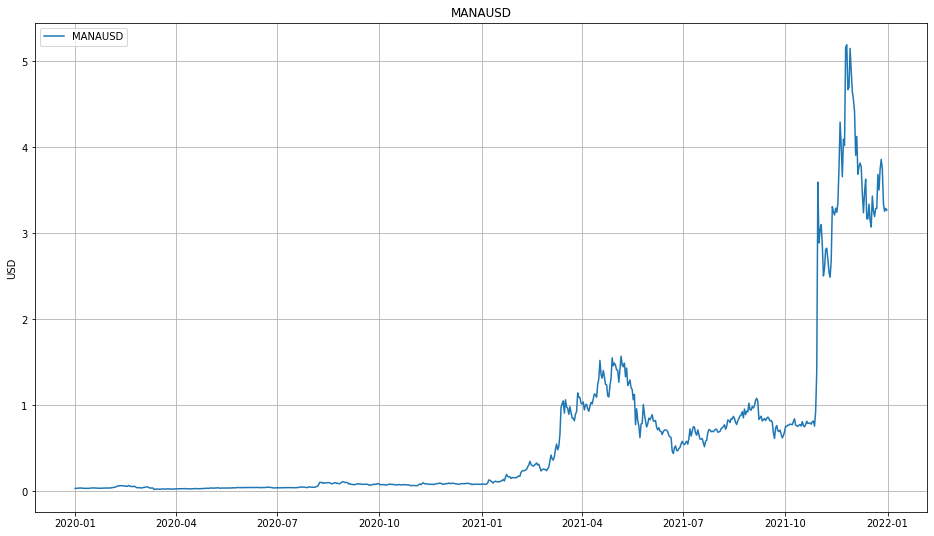

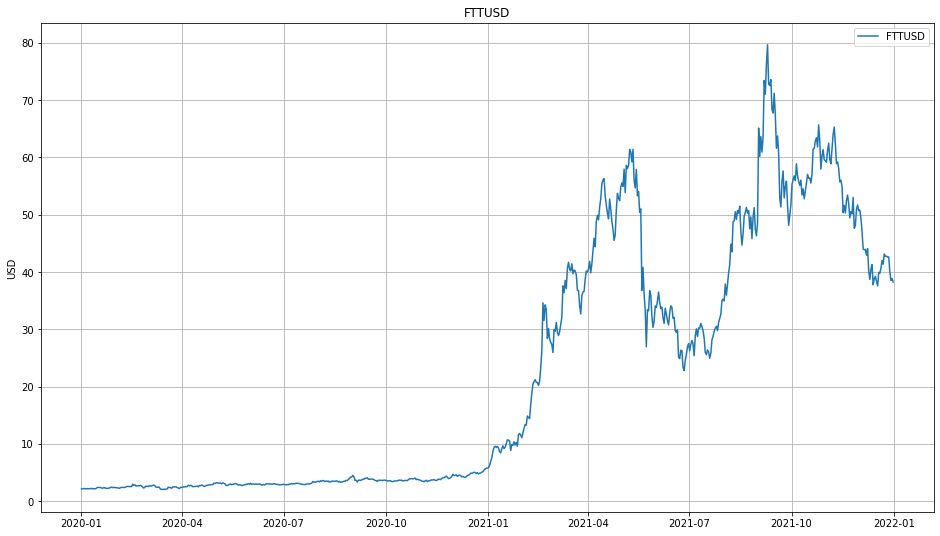

In [31]:
import matplotlib.pyplot as plt

for crypto in prices_df.columns:
    plt.figure(figsize = (16, 9))
    plt.plot(prices_df[crypto], label = crypto)
    plt.title(crypto)
    plt.legend()
    plt.ylabel('USD')
    plt.grid()
    plt.show()

In [3]:
from MethodUtil import cal_return, descriptive_statistics
return_df = cal_return(prices_df).dropna()
descriptive_statistics(return_df)

,count,mean,std,min,25%,50%,75%,max,Fisher’s kurtosis,jarque bera test(p-value)
BTCUSD,730.0,53.475219,1396.253421,-7254.420000,-352.487500,38.805000,469.930000,7576.680000,4.757018,0.0
ETHUSD,730.0,4.857000,107.835102,-932.050000,-14.675000,2.530000,25.925000,551.660000,12.068521,0.0
BNBUSD,730.0,0.681700,18.180293,-172.616916,-0.950464,0.139965,1.706297,137.894895,19.203636,0.0
ADAUSD,730.0,0.001746,0.069911,-0.534475,-0.006157,0.000373,0.009762,0.416616,11.551495,0.0
LUNAUSD,730.0,0.116765,1.684464,-9.189096,-0.025159,0.000695,0.060494,12.741233,15.261579,0.0
XRPUSD,730.0,0.000872,0.054668,-0.530427,-0.009698,0.000583,0.011200,0.356154,21.141832,0.0
LINKUSD,730.0,0.024256,1.549369,-16.297861,-0.426768,0.039760,0.494591,6.570585,19.529888,0.0
CROUSD,730.0,0.000721,0.016009,-0.122680,-0.002220,0.000455,0.003126,0.161590,38.134650,0.0
MANAUSD,730.0,0.004433,0.129155,-0.708257,-0.004732,0.000137,0.006467,2.199443,126.107424,0.0
FTTUSD,730.0,0.049470,1.801038,-14.188000,-0.176750,0.013500,0.259750,16.599000,18.098504,0.0


In [4]:
logreturn_df = cal_return(prices_df, log=True).dropna()
descriptive_statistics(logreturn_df)

,count,mean,std,min,25%,50%,75%,max,Fisher’s kurtosis,jarque bera test(p-value)
BTCUSD,730.0,0.002552,0.042389,-0.491226,-0.015920,0.002662,0.021624,0.178076,25.860735,0.0
ETHUSD,730.0,0.004576,0.055832,-0.567794,-0.020765,0.004666,0.033925,0.234751,17.383855,0.0
BNBUSD,730.0,0.004962,0.064268,-0.578000,-0.018522,0.004070,0.030988,0.533327,19.192096,0.0
ADAUSD,730.0,0.005029,0.064432,-0.524195,-0.029040,0.003675,0.034958,0.286013,7.859452,0.0
LUNAUSD,730.0,0.008090,0.083748,-0.496141,-0.029577,0.001939,0.039407,0.627527,9.731080,0.0
XRPUSD,730.0,0.002000,0.070879,-0.540382,-0.024458,0.001991,0.027671,0.450325,12.901296,0.0
LINKUSD,730.0,0.003260,0.072593,-0.638001,-0.032740,0.005014,0.041673,0.285587,11.241527,0.0
CROUSD,730.0,0.003843,0.060458,-0.393500,-0.021690,0.004851,0.029590,0.484214,11.250576,0.0
MANAUSD,730.0,0.006365,0.088457,-0.666579,-0.032670,0.002656,0.039898,0.945923,23.377381,0.0
FTTUSD,730.0,0.003949,0.051582,-0.326168,-0.022370,0.003202,0.030644,0.294288,5.643888,0.0


In [5]:
from MethodUtil import return_spreads
return_spreads_df = return_spreads(logreturn_df)
descriptive_statistics(return_spreads_df)

,count,mean,std,min,25%,50%,75%,max,Fisher’s kurtosis,jarque bera test(p-value)
"('BTCUSD', 'ETHUSD')",730.0,-0.002024,0.031854,-0.208573,-0.015470,0.001388,0.015905,0.168850,4.649547,0.0
"('BTCUSD', 'BNBUSD')",730.0,-0.002411,0.045999,-0.451824,-0.017970,0.001250,0.019460,0.271866,18.892767,0.0
"('BTCUSD', 'ADAUSD')",730.0,-0.002477,0.047613,-0.322458,-0.021099,0.003293,0.023487,0.178844,5.081820,0.0
"('BTCUSD', 'LUNAUSD')",730.0,-0.005539,0.074190,-0.449450,-0.032893,0.000925,0.031385,0.403353,6.621415,0.0
"('BTCUSD', 'XRPUSD')",730.0,0.000552,0.057404,-0.448764,-0.013539,0.003547,0.019692,0.515092,21.000900,0.0
"('BTCUSD', 'LINKUSD')",730.0,-0.000708,0.053068,-0.222243,-0.025210,0.003364,0.028621,0.328512,3.833819,0.0
"('BTCUSD', 'CROUSD')",730.0,-0.001291,0.047228,-0.544197,-0.018008,0.000685,0.020026,0.272383,28.662016,0.0
"('BTCUSD', 'MANAUSD')",730.0,-0.003813,0.074434,-0.952113,-0.027779,0.004492,0.031423,0.220792,38.099158,0.0
"('BTCUSD', 'FTTUSD')",730.0,-0.001397,0.036192,-0.348542,-0.012624,0.000498,0.014558,0.171937,17.889637,0.0
"('ETHUSD', 'BNBUSD')",730.0,-0.000386,0.045141,-0.524069,-0.015828,0.003073,0.019648,0.251136,29.299500,0.0


In [6]:
from MethodUtil import pair_selection_MSD
MSD_df = pair_selection_MSD(prices_df)

from MethodUtil import cointegration_test
cointegration_df = cointegration_test(prices_df, alpha=0.05)

pd.concat([MSD_df, cointegration_df], axis='columns')

,MSD,score,p-value,cointegration
pair,,,,
"('ETHUSD', 'BNBUSD')",56.656220,-3.307966,0.053650,False
"('ADAUSD', 'FTTUSD')",61.998617,-3.251238,0.061769,False
"('BNBUSD', 'FTTUSD')",72.138821,-2.825321,0.157761,False
"('ETHUSD', 'FTTUSD')",81.442746,-1.673531,0.688882,False
"('BNBUSD', 'XRPUSD')",101.760803,-2.239121,0.404291,False
"('CROUSD', 'MANAUSD')",104.005507,-3.237321,0.063905,False
"('ETHUSD', 'ADAUSD')",109.058555,-2.083414,0.485040,False
"('XRPUSD', 'FTTUSD')",112.155201,-3.981900,0.007620,True
"('BTCUSD', 'FTTUSD')",118.266566,-2.076765,0.488517,False


In [7]:
selected_list = [('ETHUSD', 'BNBUSD'), ('ADAUSD', 'FTTUSD'), ('BNBUSD', 'FTTUSD'), ('ETHUSD', 'FTTUSD'), ('XRPUSD', 'FTTUSD'), ('ADAUSD', 'XRPUSD')]

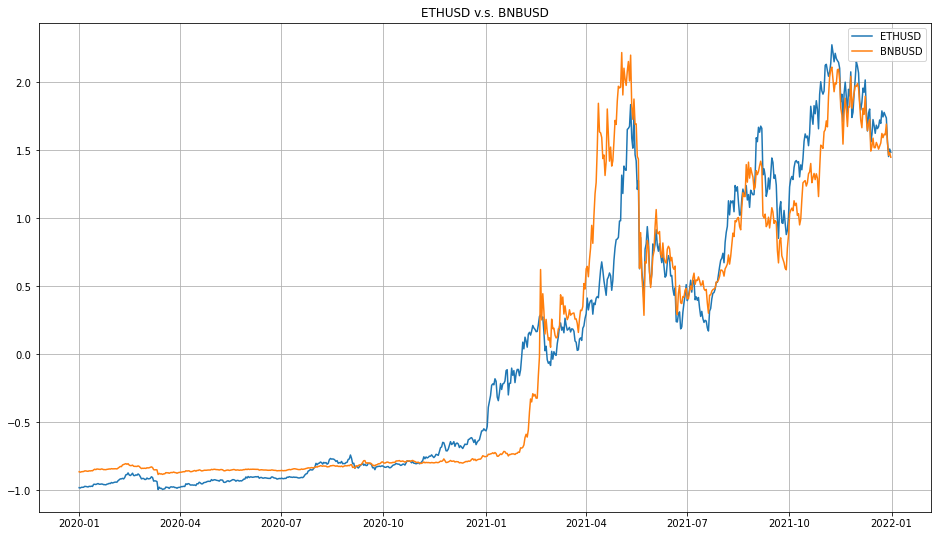

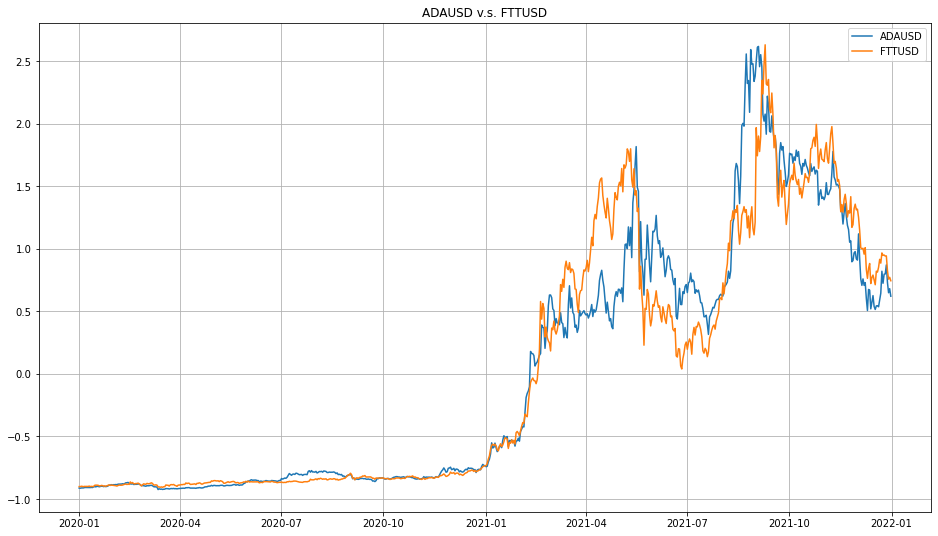

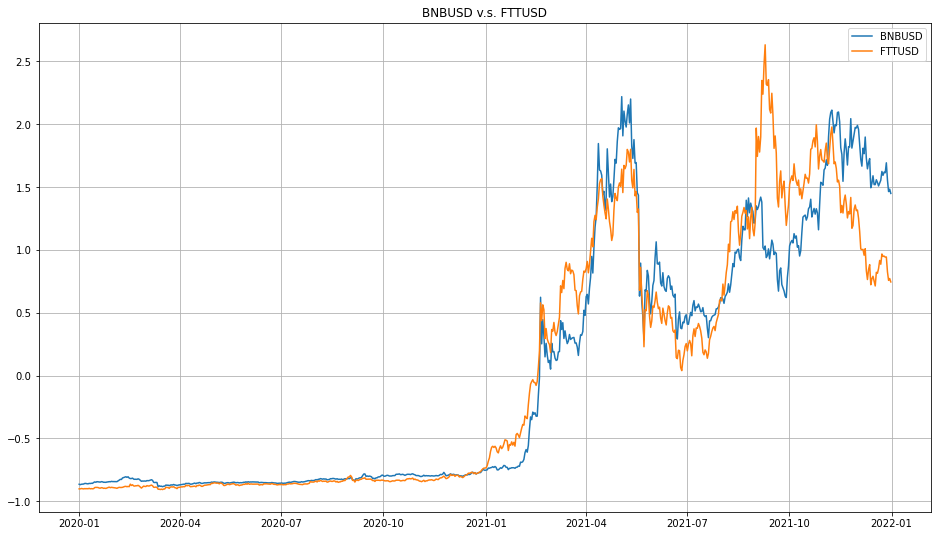

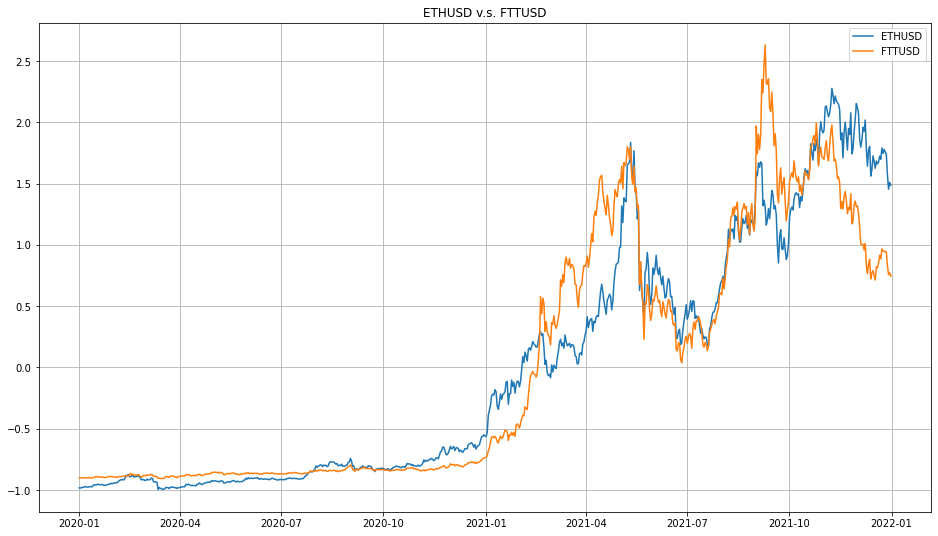

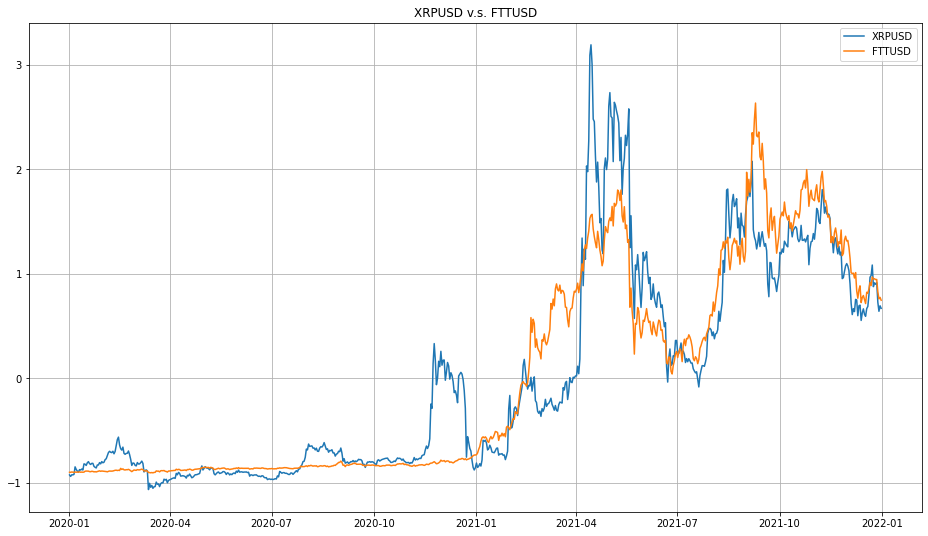

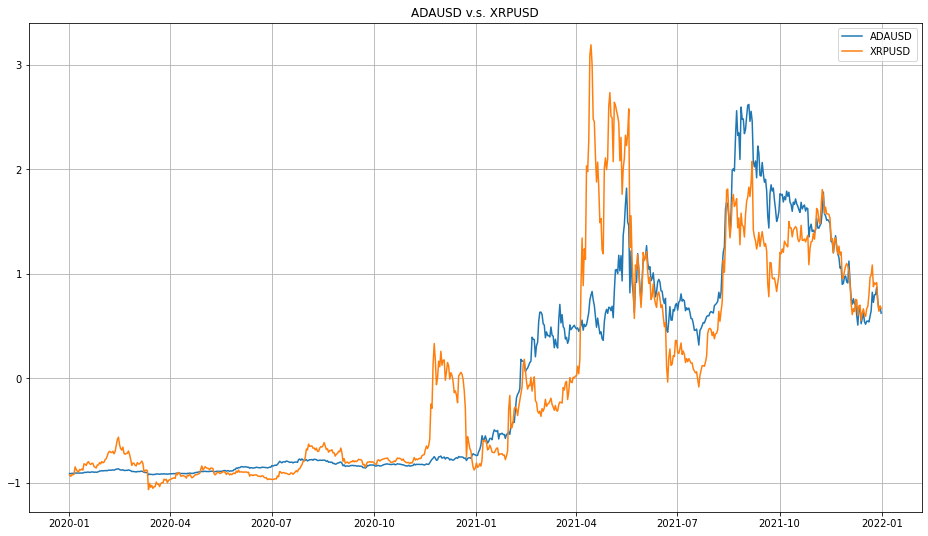

In [8]:
from MethodUtil import price_normalization
for pair in selected_list:
    prices_norm = price_normalization(prices_df)
    plt.figure(figsize = (16, 9))
    plt.plot(prices_norm[pair[0]], label = pair[0])
    plt.plot(prices_norm[pair[1]], label = pair[1])
    plt.title(f'{pair[0]} v.s. {pair[1]}')
    plt.legend()
    plt.grid()
    plt.show()

In [21]:
from MethodUtil import ForecastModel
from arch.univariate import *
model_list = []
for pair in selected_list:
    for vol in [GARCH(1,0,1), GARCH(1,1,1), EGARCH(1,0,1)]:
        for dist in [Normal(), StudentsT(), SkewStudent()]:
            for alpha in [[0.2, 0.8],[0.1, 0.9]]:
                Model = ForecastModel(return_spreads_df, pair=pair)
                Model.modelspec(vol=vol, dist=dist)
                Model.rollingForecasting(window=365, VaR_alpha=alpha)
                model_list.append(Model)

C:\Users\arthu\.conda\envs\PairsTrading\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\arthu\.conda\envs\PairsTrading\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\arthu\.conda\envs\PairsTrading\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\arthu\.conda\envs\PairsTrading\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearc

In [22]:
from MethodUtil import Strategy
dfs = []
for model in model_list:
    strategy = Strategy(prices_df, model)
    tmp_df = strategy.performance(date_start='2021-01-01')
    dfs.append(tmp_df)
result_df = pd.concat(dfs, ignore_index=True)
result_df.to_csv('result.csv')
result_df

,Currency A,A Return%,Currency B,B Return%,trades,Pair Return%
0,ETHUSD,402.852296,BNBUSD,1251.003802,81,342.744800
1,ETHUSD,402.852296,BNBUSD,1251.003802,40,831.455113
2,ETHUSD,402.852296,BNBUSD,1251.003802,87,315.164150
3,ETHUSD,402.852296,BNBUSD,1251.003802,44,617.356340
4,ETHUSD,402.852296,BNBUSD,1251.003802,87,328.409888
...,...,...,...,...,...,...
103,ADAUSD,645.120444,XRPUSD,248.370917,35,292.208859
104,ADAUSD,645.120444,XRPUSD,248.370917,98,252.904009
105,ADAUSD,645.120444,XRPUSD,248.370917,56,630.609099
106,ADAUSD,645.120444,XRPUSD,248.370917,98,252.904009


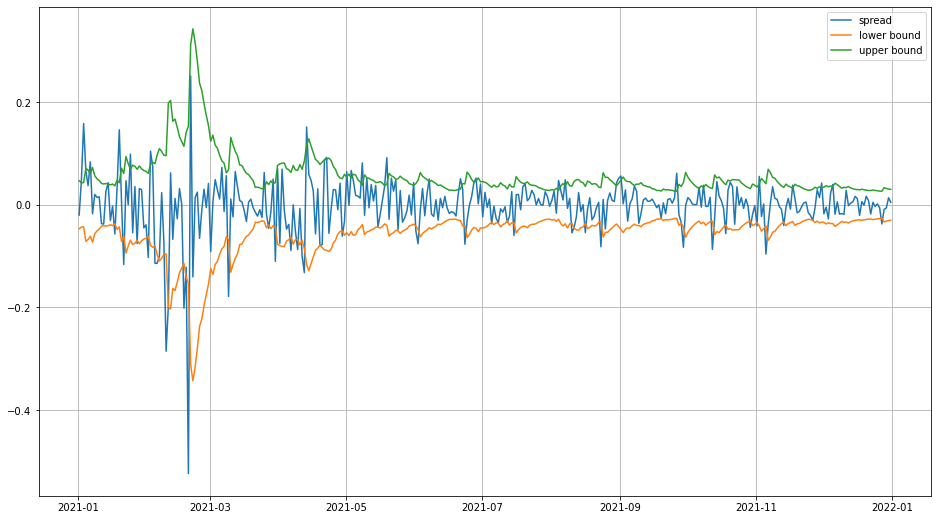

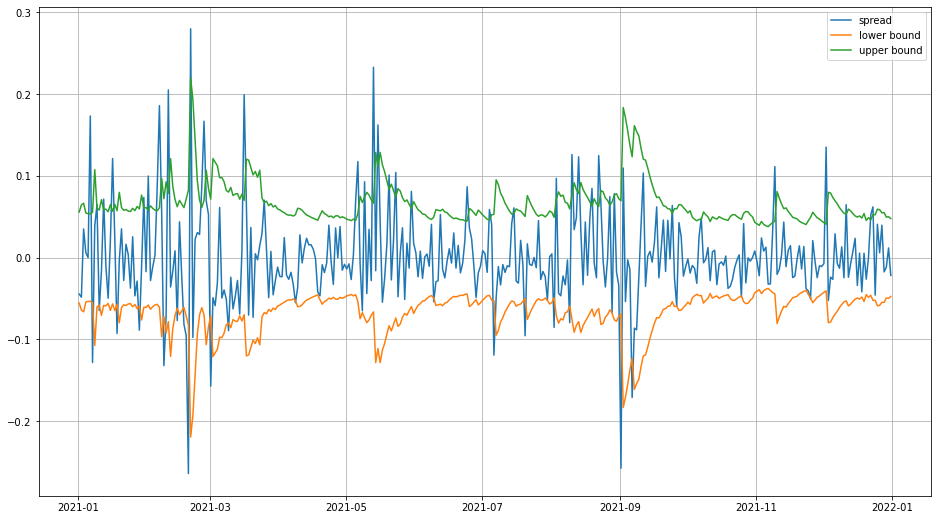

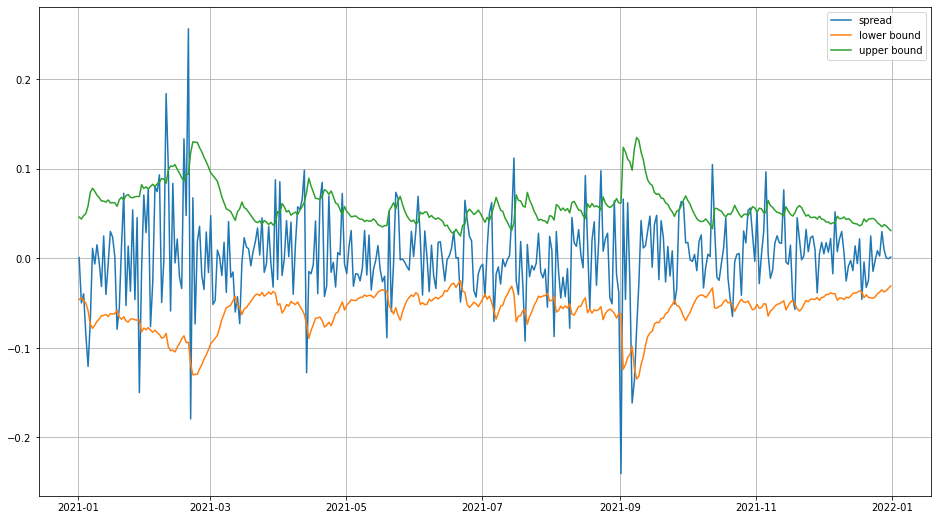

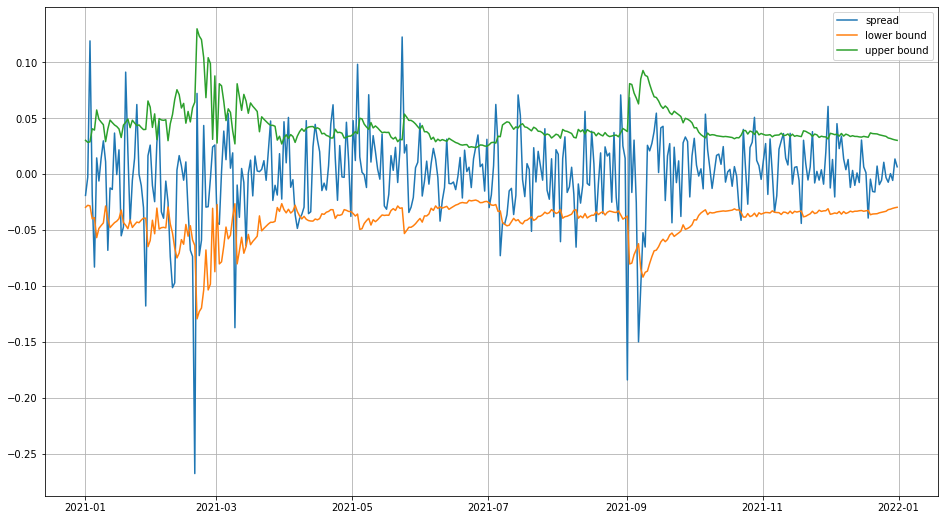

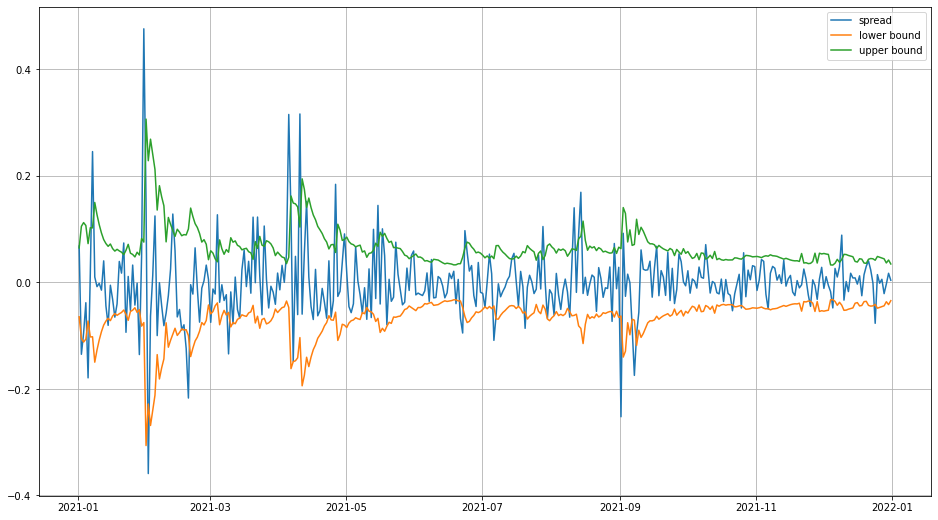

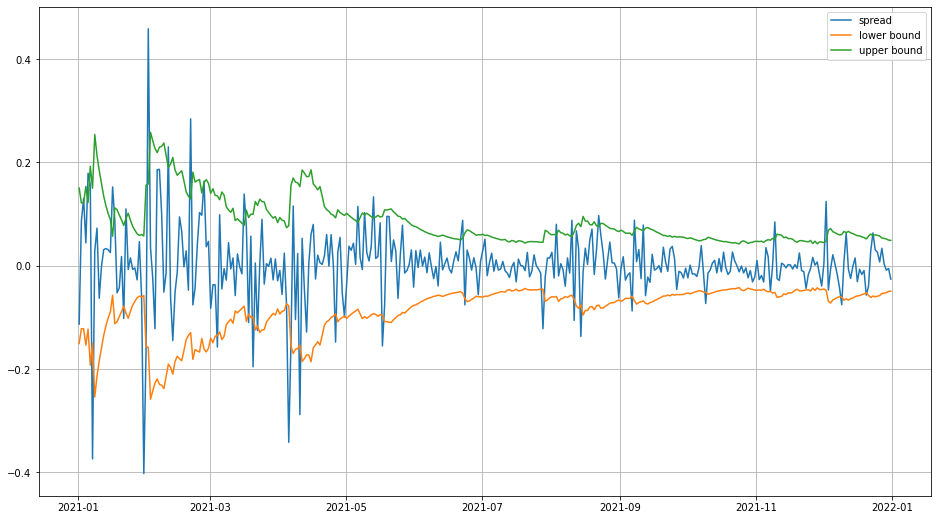

In [32]:
for i in [9, 25, 49, 63, 75, 97]:
    strategy = Strategy(prices_df, model_list[i])
    plt.figure(figsize = (16, 9))
    plt.plot(strategy.spreadall['2021-01-01':], label = 'spread')
    plt.plot(strategy.lowerVaR, label = 'lower bound')
    plt.plot(strategy.upperVaR, label = 'upper bound')
    plt.title('')
    plt.legend()
    plt.grid()
    plt.show()

In [36]:
model_list[9].res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - GJR-GARCH Model Results                         
====================================================================================
Dep. Variable:         ('ETHUSD', 'BNBUSD')   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.003
Vol Model:                        GJR-GARCH   Log-Likelihood:                651.521
Distribution:      Standardized Student's t   AIC:                          -1293.04
Method:                  Maximum Likelihood   BIC:                          -1273.54
                                              No. Observations:                  365
Date:                      Tue, Jan 11 2022   Df Residuals:                      365
Time:                              02:06:40   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.4324e-05  1.381e-04      0.466      0.641 [-2.064e-04,3.350e-04]
alpha[1]       0.1000  6.718e-02      1.489      0.137   [-3.166e-02,  0.232]
gamma[1]       0.1000      0.333      0.300      0.764      [ -0.553,  0.753]
beta[1]        0.8300      0.211      3.942  8.081e-05      [  0.417,  1.243]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             7.5127      6.665      1.127      0.260 [ -5.550, 20.576]
========================================================================

Covariance estimator: robust
"""

In [37]:
model_list[25].res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Zero Mean - GJR-GARCH Model Results                       
================================================================================
Dep. Variable:     ('ADAUSD', 'FTTUSD')   R-squared:                       0.000
Mean Model:                   Zero Mean   Adj. R-squared:                  0.003
Vol Model:                    GJR-GARCH   Log-Likelihood:                563.485
Distribution:                    Normal   AIC:                          -1118.97
Method:              Maximum Likelihood   BIC:                          -1103.37
                                          No. Observations:                  365
Date:                  Tue, Jan 11 2022   Df Residuals:                      365
Time:                          02:08:42   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3314e-04  6.702e-05      1.987  4.697e-02 [1.781e-06,2.645e-04]
alpha[1]       0.1347  5.694e-02      2.365  1.803e-02   [2.307e-02,  0.246]
gamma[1]       0.0398      0.101      0.394      0.693     [ -0.158,  0.237]
beta[1]        0.8155  4.465e-02     18.262  1.675e-74     [  0.728,  0.903]
============================================================================

Covariance estimator: robust
"""

In [38]:
model_list[49].res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - EGARCH Model Results                        
================================================================================
Dep. Variable:     ('BNBUSD', 'FTTUSD')   R-squared:                       0.000
Mean Model:                   Zero Mean   Adj. R-squared:                  0.003
Vol Model:                       EGARCH   Log-Likelihood:                623.361
Distribution:                    Normal   AIC:                          -1240.72
Method:              Maximum Likelihood   BIC:                          -1229.02
                                          No. Observations:                  365
Date:                  Tue, Jan 11 2022   Df Residuals:                      365
Time:                          02:12:01   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         -0.2790      0.236     -1.182      0.237   [ -0.741,  0.184]
alpha[1]       0.2457  7.604e-02      3.231  1.232e-03 [9.668e-02,  0.395]
beta[1]        0.9539  3.748e-02     25.449 7.204e-143   [  0.880,  1.027]
==========================================================================

Covariance estimator: robust
"""

In [39]:
model_list[63].res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - GJR-GARCH Model Results                         
====================================================================================
Dep. Variable:         ('ETHUSD', 'FTTUSD')   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.003
Vol Model:                        GJR-GARCH   Log-Likelihood:                728.225
Distribution:      Standardized Student's t   AIC:                          -1446.45
Method:                  Maximum Likelihood   BIC:                          -1426.95
                                              No. Observations:                  365
Date:                      Tue, Jan 11 2022   Df Residuals:                      365
Time:                              02:13:44   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.1161e-04  5.730e-05      1.948  5.145e-02 [-7.041e-07,2.239e-04]
alpha[1]       0.0178  4.483e-02      0.396      0.692   [-7.010e-02,  0.106]
gamma[1]       0.1130  7.888e-02      1.433      0.152   [-4.159e-02,  0.268]
beta[1]        0.8376  5.773e-02     14.511  1.038e-47      [  0.725,  0.951]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.1159      0.879      4.684  2.812e-06 [  2.394,  5.838]
========================================================================

Covariance estimator: robust
"""

In [40]:
model_list[75].res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Zero Mean - GARCH Model Results                           
====================================================================================
Dep. Variable:         ('XRPUSD', 'FTTUSD')   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.003
Vol Model:                            GARCH   Log-Likelihood:                564.343
Distribution:      Standardized Student's t   AIC:                          -1120.69
Method:                  Maximum Likelihood   BIC:                          -1105.09
                                              No. Observations:                  365
Date:                      Tue, Jan 11 2022   Df Residuals:                      365
Time:                              02:15:18   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.5329e-05  3.929e-05      0.899      0.369 [-4.168e-05,1.123e-04]
alpha[1]       0.0471  4.264e-02      1.104      0.270   [-3.650e-02,  0.131]
beta[1]        0.9412  4.758e-02     19.784  4.112e-87      [  0.848,  1.034]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.2407      0.527      6.145  7.972e-10 [  2.207,  4.274]
========================================================================

Covariance estimator: robust
"""

In [41]:
model_list[97].res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Zero Mean - GJR-GARCH Model Results                       
================================================================================
Dep. Variable:     ('ADAUSD', 'XRPUSD')   R-squared:                       0.000
Mean Model:                   Zero Mean   Adj. R-squared:                  0.003
Vol Model:                    GJR-GARCH   Log-Likelihood:                529.674
Distribution:                    Normal   AIC:                          -1051.35
Method:              Maximum Likelihood   BIC:                          -1035.75
                                          No. Observations:                  365
Date:                  Tue, Jan 11 2022   Df Residuals:                      365
Time:                          02:18:05   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.0534e-04  7.848e-05      1.342      0.180 [-4.848e-05,2.592e-04]
alpha[1]       0.0500  5.953e-02      0.840      0.401   [-6.668e-02,  0.167]
gamma[1]       0.1000  9.515e-02      1.051      0.293   [-8.650e-02,  0.286]
beta[1]        0.8800  5.404e-02     16.283  1.305e-59      [  0.774,  0.986]
=============================================================================

Covariance estimator: robust
"""